# Project 1: Linear Regression from Scratch in PyTorch

A progressive implementation of linear regression in PyTorch — from fully manual gradient descent to using `nn.Module` and proper ML evaluation practices.

**Concepts Covered:**
- Tensors, autograd, and computation graphs
- Manual gradient descent
- `nn.Module`, `nn.Linear`
- Loss functions (`MSELoss`) and optimizers (`SGD`, `Adam`)
- Learning rate effects on convergence
- Train/test split and evaluation metrics (MSE, MAE, R²)
- `model.train()` vs `model.eval()`
- Model saving and loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


---
## Phase 1: Completely Manual (No nn.Module)

Understanding what's really happening under the hood — no shortcuts.

**Goal:** Learn `y = 4x + 2` from noisy data using manual gradient descent.

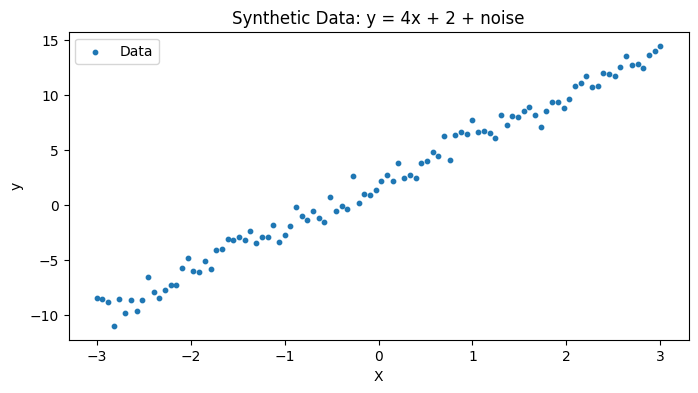

In [2]:
# Generate synthetic data: y = 4x + 2 + noise
torch.manual_seed(42)
X = torch.linspace(-3, 3, 100).reshape(-1, 1)
y_true = 4 * X + 2 + torch.randn(100, 1) * 0.8

# Visualize the data
plt.figure(figsize=(8, 4))
plt.scatter(X.numpy(), y_true.numpy(), s=10, label="Data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Data: y = 4x + 2 + noise")
plt.legend()
plt.show()

In [3]:
# Initialize parameters manually
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
learning_rate = 0.01

print(f"Initial: w={w.item():.4f}, b={b.item():.4f}")

# Training loop - pure manual gradient descent
losses = []

for epoch in range(200):
    # Forward pass: y_pred = wx + b
    y_pred = w * X + b
    
    # Loss: MSE = mean((y_pred - y_true)²)
    loss = ((y_pred - y_true) ** 2).mean()
    
    # Backward pass - compute gradients
    loss.backward()
    
    # Update parameters (must be inside no_grad to prevent tracking)
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
    
    # Zero gradients for next iteration
    w.grad.zero_()
    b.grad.zero_()
    
    losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | w: {w.item():.4f} | b: {b.item():.4f}")

print(f"\nFinal: w={w.item():.4f} (target: 4.0), b={b.item():.4f} (target: 2.0)")

Initial: w=-0.5672, b=-0.5706
Epoch   0 | Loss: 71.0946 | w: -0.2881 | b: -0.5183
Epoch  20 | Loss: 8.7573 | w: 2.7821 | b: 0.3347
Epoch  40 | Loss: 2.3847 | w: 3.6500 | b: 0.9041
Epoch  60 | Loss: 1.2558 | w: 3.8954 | b: 1.2843
Epoch  80 | Loss: 0.8894 | w: 3.9648 | b: 1.5381
Epoch 100 | Loss: 0.7371 | w: 3.9844 | b: 1.7075
Epoch 120 | Loss: 0.6700 | w: 3.9900 | b: 1.8206
Epoch 140 | Loss: 0.6402 | w: 3.9915 | b: 1.8961
Epoch 160 | Loss: 0.6269 | w: 3.9920 | b: 1.9466
Epoch 180 | Loss: 0.6210 | w: 3.9921 | b: 1.9802

Final: w=3.9921 (target: 4.0), b=2.0018 (target: 2.0)


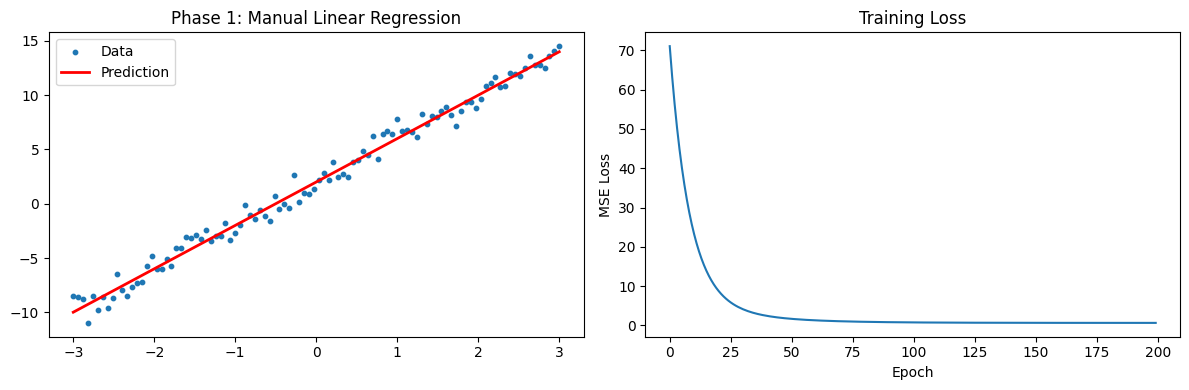

In [4]:
# Visualize Phase 1 results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Model fit
axes[0].scatter(X.numpy(), y_true.numpy(), s=10, label="Data")
with torch.no_grad():
    axes[0].plot(X.numpy(), (w * X + b).numpy(), color="red", linewidth=2, label="Prediction")
axes[0].set_title("Phase 1: Manual Linear Regression")
axes[0].legend()

# Loss curve
axes[1].plot(losses)
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE Loss")

plt.tight_layout()
plt.show()

### Experiment: Learning Rate Effects

Observing how different learning rates affect convergence:
- `lr = 0.001` → Too slow, barely learns in 200 epochs
- `lr = 0.01` → Just right, smooth convergence
- `lr = 0.1` → Fast convergence, loss drops almost vertically
- `lr = 1.0` → Loss explodes to infinity

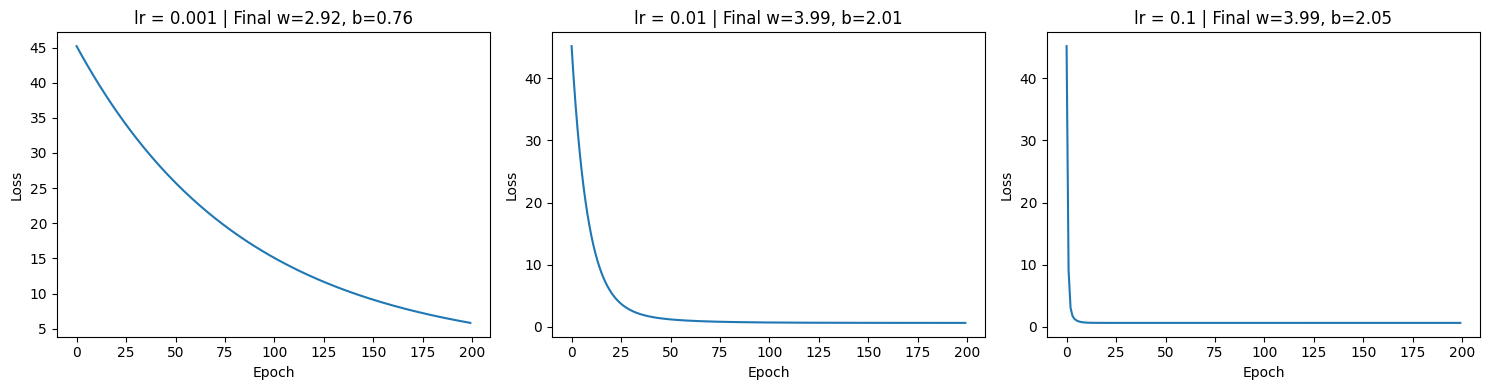

In [5]:
# Learning rate comparison
learning_rates = [0.001, 0.01, 0.1]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, lr in enumerate(learning_rates):
    torch.manual_seed(42)
    w_exp = torch.randn(1, requires_grad=True)
    b_exp = torch.randn(1, requires_grad=True)
    exp_losses = []
    
    for epoch in range(200):
        y_pred = w_exp * X + b_exp
        loss = ((y_pred - y_true) ** 2).mean()
        loss.backward()
        with torch.no_grad():
            w_exp -= lr * w_exp.grad
            b_exp -= lr * b_exp.grad
        w_exp.grad.zero_()
        b_exp.grad.zero_()
        exp_losses.append(loss.item())
    
    axes[i].plot(exp_losses)
    axes[i].set_title(f"lr = {lr} | Final w={w_exp.item():.2f}, b={b_exp.item():.2f}")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")

plt.tight_layout()
plt.show()

---
## Phase 2: Using nn.Module and Optimizer

Same problem, but using PyTorch's built-in abstractions.

| Phase 1 (Manual) | Phase 2 (PyTorch Way) |
|---|---|
| `w = torch.randn(requires_grad=True)` | `nn.Linear(1, 1)` |
| `y_pred = w * X + b` | `y_pred = model(X)` |
| `((y_pred - y_true)**2).mean()` | `nn.MSELoss()` |
| `w -= lr * w.grad` | `optimizer.step()` |
| `w.grad.zero_()` | `optimizer.zero_grad()` |

In [6]:
# Define model using nn.Module
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # automatically creates weight and bias
    
    def forward(self, x):
        return self.linear(x)

model = LinearRegression()

# Inspect auto-created parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

linear.weight: tensor([[-0.2191]])
linear.bias: tensor([0.2018])


In [7]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
losses_p2 = []

for epoch in range(200):
    y_pred = model(X)                     # forward pass
    loss = criterion(y_pred, y_true)       # compute loss
    
    optimizer.zero_grad()                  # zero gradients
    loss.backward()                        # compute gradients
    optimizer.step()                       # update weights
    
    losses_p2.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f}")

w_learned = model.linear.weight.item()
b_learned = model.linear.bias.item()
print(f"\nLearned: w={w_learned:.4f} (target: 4.0), b={b_learned:.4f} (target: 2.0)")

Epoch   0 | Loss: 58.3026
Epoch  20 | Loss: 6.4735
Epoch  40 | Loss: 1.6400
Epoch  60 | Loss: 0.9457
Epoch  80 | Loss: 0.7529
Epoch 100 | Loss: 0.6764
Epoch 120 | Loss: 0.6430
Epoch 140 | Loss: 0.6282
Epoch 160 | Loss: 0.6216
Epoch 180 | Loss: 0.6186

Learned: w=3.9921 (target: 4.0), b=2.0153 (target: 2.0)


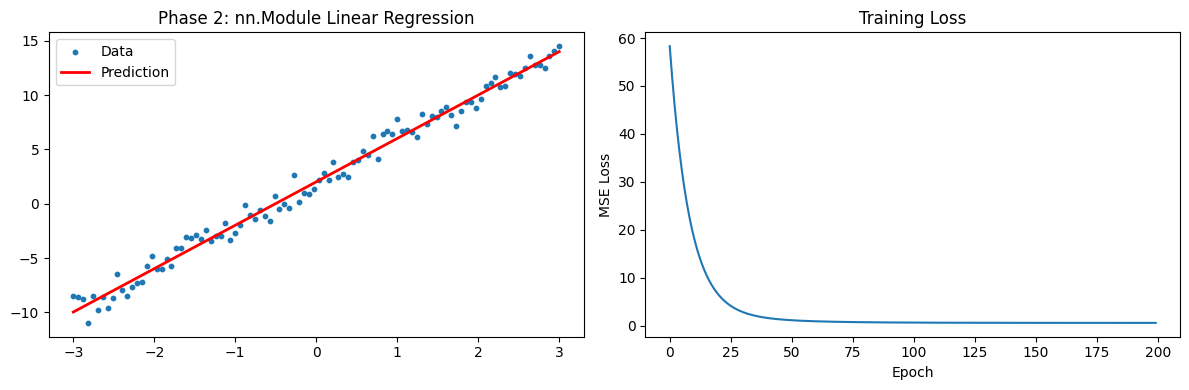

In [8]:
# Visualize Phase 2 results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(X.numpy(), y_true.numpy(), s=10, label="Data")
with torch.no_grad():
    axes[0].plot(X.numpy(), model(X).numpy(), color="red", linewidth=2, label="Prediction")
axes[0].set_title("Phase 2: nn.Module Linear Regression")
axes[0].legend()

axes[1].plot(losses_p2)
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE Loss")

plt.tight_layout()
plt.show()

---
## Phase 3: Train/Test Split, Evaluation, and Model Saving

Proper ML practices — training loss alone means nothing. What matters is performance on **unseen data**.

In [9]:
# Regenerate data for clean Phase 3
torch.manual_seed(42)
X = torch.linspace(-3, 3, 100).reshape(-1, 1)
y_true = 4 * X + 2 + torch.randn(100, 1) * 0.8

# Train/Test Split (80/20)
indices = torch.randperm(100)
train_idx = indices[:80]
test_idx = indices[80:]

X_train, y_train = X[train_idx], y_true[train_idx]
X_test, y_test = X[test_idx], y_true[test_idx]

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

Train: 80 samples
Test:  20 samples


In [10]:
# Model, loss, optimizer
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop with train AND test loss tracking
train_losses = []
test_losses = []

for epoch in range(200):
    # Training
    model.train()
    y_pred = model(X_train)
    train_loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = criterion(y_test_pred, y_test)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

Epoch   0 | Train Loss: 33.1313 | Test Loss: 25.5902
Epoch  20 | Train Loss: 4.2967 | Test Loss: 4.1409
Epoch  40 | Train Loss: 1.4700 | Test Loss: 1.7949
Epoch  60 | Train Loss: 0.9367 | Test Loss: 1.2234
Epoch  80 | Train Loss: 0.7516 | Test Loss: 0.9711
Epoch 100 | Train Loss: 0.6729 | Test Loss: 0.8390
Epoch 120 | Train Loss: 0.6381 | Test Loss: 0.7661
Epoch 140 | Train Loss: 0.6226 | Test Loss: 0.7244
Epoch 160 | Train Loss: 0.6157 | Test Loss: 0.6996
Epoch 180 | Train Loss: 0.6126 | Test Loss: 0.6846


In [11]:
# Evaluation metrics on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    
    # MSE
    mse = criterion(y_test_pred, y_test).item()
    
    # MAE
    mae = torch.abs(y_test_pred - y_test).mean().item()
    
    # R² Score
    ss_res = ((y_test - y_test_pred) ** 2).sum()
    ss_tot = ((y_test - y_test.mean()) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot)

print(f"--- Test Set Metrics ---")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2.item():.4f}")

--- Test Set Metrics ---
MSE:  0.6755
MAE:  0.6507
R²:   0.9831


In [12]:
# Save and load model
torch.save(model.state_dict(), "linear_model.pth")
print("Model saved!")

# Load it back
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load("linear_model.pth"))
loaded_model.eval()
print("Model loaded!")

# Verify predictions match
with torch.no_grad():
    original_pred = model(X_test)
    loaded_pred = loaded_model(X_test)
    print(f"Predictions match: {torch.allclose(original_pred, loaded_pred)}")

Model saved!
Model loaded!
Predictions match: True


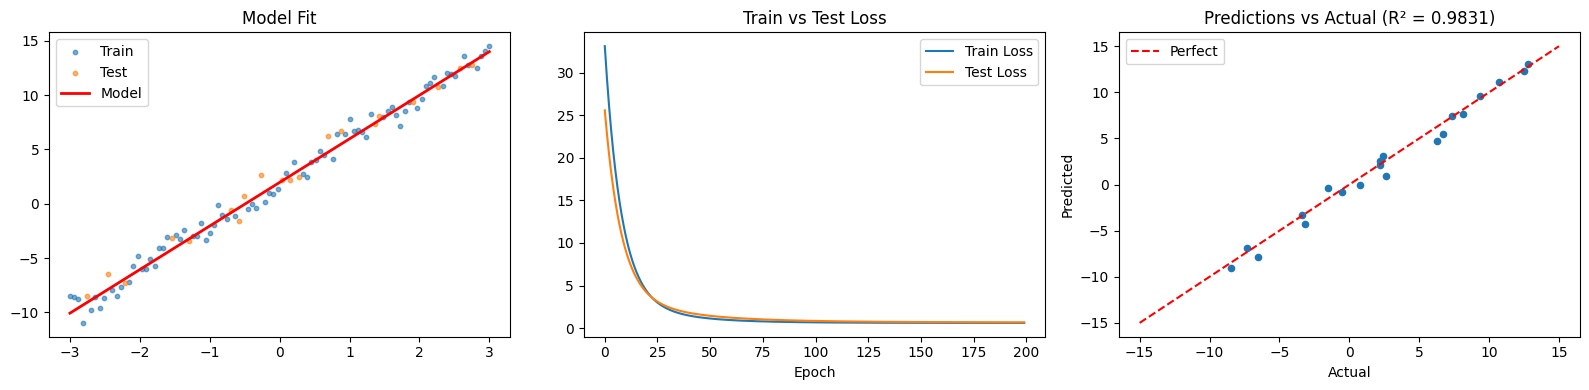

In [13]:
# Final visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Model fit with train/test split
axes[0].scatter(X_train.numpy(), y_train.numpy(), s=10, label="Train", alpha=0.6)
axes[0].scatter(X_test.numpy(), y_test.numpy(), s=10, label="Test", alpha=0.6)
with torch.no_grad():
    axes[0].plot(X.numpy(), model(X).numpy(), color="red", linewidth=2, label="Model")
axes[0].set_title("Model Fit")
axes[0].legend()

# Train vs test loss
axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(test_losses, label="Test Loss")
axes[1].set_title("Train vs Test Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend()

# Predictions vs actual
with torch.no_grad():
    y_test_pred = model(X_test)
axes[2].scatter(y_test.numpy(), y_test_pred.numpy(), s=20)
axes[2].plot([-15, 15], [-15, 15], color="red", linestyle="--", label="Perfect")
axes[2].set_xlabel("Actual")
axes[2].set_ylabel("Predicted")
axes[2].set_title(f"Predictions vs Actual (R² = {r2.item():.4f})")
axes[2].legend()

plt.tight_layout()
plt.show()

---
## Key Takeaways

### Concepts Learned
1. **Tensors & Autograd** — PyTorch tracks operations and computes gradients automatically via computation graphs
2. **Manual vs nn.Module** — `nn.Module` handles parameter creation, forward pass, and gradient management
3. **Training Loop Pattern** — Forward → Loss → Zero Grad → Backward → Step (same for every model)
4. **Learning Rate** — Too high = divergence, too low = slow convergence, just right = smooth descent
5. **Train/Test Split** — Evaluate on unseen data to detect overfitting
6. **model.train() vs model.eval()** — Critical for dropout and batch normalization in deeper models
7. **Model Saving** — `torch.save(model.state_dict())` is the recommended approach

### Test your knowledge
- Explain what `.backward()` does (chain rule over computation graph)
- Why `optimizer.zero_grad()` is needed (gradients accumulate by default)
- Effects of learning rate on training
- SGD vs Adam and when to use each
- How to detect overfitting from loss curves
- R² interpretation